In [284]:
import pytz
import time
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import optuna
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [252]:
df = pd.read_csv('Japan earthquakes 2001 - 2018.csv')

In [28]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2018-11-27T14:34:20.900Z,48.3780,154.9620,35.00,4.9,mb,NaN,92.0,5.044,0.63,...,2018-11-27T16:06:33.040Z,"269km SSW of Severo-Kuril'sk, Russia",earthquake,7.6,1.7,0.036,248.0,reviewed,us,us
1,2018-11-26T23:33:50.630Z,36.0733,139.7830,48.82,4.8,mww,NaN,113.0,1.359,1.13,...,2018-11-27T16:44:22.223Z,"3km SSW of Sakai, Japan",earthquake,6.0,6.1,0.071,19.0,reviewed,us,us
2,2018-11-26T13:04:02.250Z,38.8576,141.8384,50.56,4.5,mb,NaN,145.0,1.286,0.84,...,2018-11-26T23:52:21.074Z,"26km SSE of Ofunato, Japan",earthquake,8.4,9.5,0.156,12.0,reviewed,us,us
3,2018-11-26T05:20:16.440Z,50.0727,156.1420,66.34,4.6,mb,NaN,128.0,3.191,0.62,...,2018-11-26T08:13:58.040Z,"67km S of Severo-Kuril'sk, Russia",earthquake,9.7,7.8,0.045,151.0,reviewed,us,us
4,2018-11-25T09:19:05.010Z,33.9500,134.4942,38.19,4.6,mb,NaN,104.0,0.558,0.61,...,2018-11-25T23:24:52.615Z,"9km SW of Komatsushima, Japan",earthquake,3.4,10.1,0.132,17.0,reviewed,us,us


Drop the duplicated entries.

In [3]:
df.drop_duplicates(['time','latitude','longitude','mag'], keep='first')

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2018-11-27T14:34:20.900Z,48.3780,154.9620,35.00,4.9,mb,NaN,92.0,5.044,0.63,...,2018-11-27T16:06:33.040Z,"269km SSW of Severo-Kuril'sk, Russia",earthquake,7.6,1.7,0.036,248.0,reviewed,us,us
1,2018-11-26T23:33:50.630Z,36.0733,139.7830,48.82,4.8,mww,NaN,113.0,1.359,1.13,...,2018-11-27T16:44:22.223Z,"3km SSW of Sakai, Japan",earthquake,6.0,6.1,0.071,19.0,reviewed,us,us
2,2018-11-26T13:04:02.250Z,38.8576,141.8384,50.56,4.5,mb,NaN,145.0,1.286,0.84,...,2018-11-26T23:52:21.074Z,"26km SSE of Ofunato, Japan",earthquake,8.4,9.5,0.156,12.0,reviewed,us,us
3,2018-11-26T05:20:16.440Z,50.0727,156.1420,66.34,4.6,mb,NaN,128.0,3.191,0.62,...,2018-11-26T08:13:58.040Z,"67km S of Severo-Kuril'sk, Russia",earthquake,9.7,7.8,0.045,151.0,reviewed,us,us
4,2018-11-25T09:19:05.010Z,33.9500,134.4942,38.19,4.6,mb,NaN,104.0,0.558,0.61,...,2018-11-25T23:24:52.615Z,"9km SW of Komatsushima, Japan",earthquake,3.4,10.1,0.132,17.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14087,2001-01-04T04:18:21.430Z,36.9810,138.6290,21.40,5.3,mwc,240.0,NaN,NaN,0.78,...,2016-11-09T21:35:38.927Z,"eastern Honshu, Japan",earthquake,NaN,5.4,NaN,NaN,reviewed,us,hrv
14088,2001-01-03T14:47:49.540Z,43.9320,147.8130,33.00,5.9,mwc,362.0,NaN,NaN,0.82,...,2016-11-09T04:09:27.754Z,Kuril Islands,earthquake,NaN,NaN,NaN,NaN,reviewed,us,hrv
14089,2001-01-03T09:32:54.710Z,45.3010,149.9410,33.00,4.6,mb,40.0,NaN,NaN,0.82,...,2014-11-07T01:11:51.270Z,Kuril Islands,earthquake,NaN,NaN,NaN,20.0,reviewed,us,us
14090,2001-01-02T20:29:49.670Z,32.2390,141.5080,33.00,4.9,mb,32.0,NaN,NaN,0.96,...,2014-11-07T01:11:51.119Z,"Izu Islands, Japan region",earthquake,NaN,NaN,NaN,23.0,reviewed,us,us


In [30]:
df.magType.unique()

array(['mb', 'mww', 'mwr', 'mwb', 'mwc', 'ms', 'mw', 'm'], dtype=object)

Need to set the time column as the index. But before doing that some conversion is needed.

In [253]:
#Rename name the mag column to magnitude
df.rename(columns={'mag':'magnitude'},inplace=True)

#conver the data type of time column to datetime
df['time'] = pd.to_datetime(df['time'])

#sort values by time in ascending order
df.sort_values(by='time',inplace=True)

#set the time column as the index
df.set_index('time',inplace=True)

# Training-modeling

### 1. Forecasting using ARIMA model.

**Stationarity check**<br>ARIMA model requires the data to be stationary. So the block below performs the check and converts the non-stationary data to stationary.

In [13]:
# Function to check for stationarity and perform differencing if necessary
def make_stationary(data):
    result = adfuller(data)
    p_value = result[1]
    if p_value > 0.05:  # Data is non-stationary
        print("Data is non-stationary. Performing differencing...")
        return data.diff().dropna()  # Perform first-order differencing
    else:  # Data is stationary
        return data

# Make the data stationary
stationary_data = make_stationary(df['magnitude'])

We'll find the optimum order for the ARIMA model by training on small portion of the data.<br>
Let's take 7% data for training and testing purpose.

In [32]:
df2 = df[:1000]

# Splitting data into training and testing sets
train_size = int(len(df2) * 0.8)
train, test = df2[:train_size], df2[train_size:]
print(train_size, train.shape, test.shape)

800 (800, 21) (200, 21)


Now, time to run the block to find the optimum order.

In [16]:
start_time = time.time()
current_time = datetime.now()
print('Started at: ',current_time.strftime("%H:%M:%S"))

# Function to evaluate ARIMA model
def evaluate_arima_model(data, order):
    train, test = data[:train_size], data[train_size:]
    history = [x for x in train['magnitude']]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test['magnitude'][t])

    mse = mean_squared_error(test['magnitude'], predictions)
    return mse

# Find the best ARIMA model hyperparameters (p, d, q)
best_mse = float('inf')
best_order = None

for p in range(3):
    for d in range(3):
        for q in range(3):
            order = (p, d, q)
            try:
                mse = evaluate_arima_model(df2, order)
                if mse < best_mse:
                    best_mse = mse
                    best_order = order
            except:
                continue

completition_time = time.time()
elapsed_time = (completition_time - start_time)/60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

print('best_order:',best_order)

Started at:  17:24:28
Elapsed time: 23.91 minutes
best_order: (1, 2, 2)


In [28]:
# Train the final ARIMA model with the best hyperparameters
# best_order= (2,0,2)
model = ARIMA(df1['magnitude'], order=best_order)
model_fit = model.fit()

# Forecast future earthquakes
forecast_steps = 90  # Change this based on how many steps you want to forecast
forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Print the forecasted magnitudes
print("Forecasted magnitudes:")
print(forecast)

Forecasted magnitudes:
14092    4.787595
14093    4.783094
14094    4.782926
14095    4.782932
14096    4.782945
           ...   
14177    4.784021
14178    4.784034
14179    4.784048
14180    4.784061
14181    4.784074
Name: predicted_mean, Length: 90, dtype: float64


In [20]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              magnitude   No. Observations:                14092
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -5872.205
Date:                Thu, 27 Jul 2023   AIC                          11752.410
Time:                        17:49:18   BIC                          11782.623
Sample:                             0   HQIC                         11762.465
                              - 14092                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0401      0.008      5.027      0.000       0.024       0.056
ma.L1         -1.9678      0.002  -1144.249      0.000      -1.971      -1.964
ma.L2          0.9678      0.002    561.665      0.000       0.964       0.971
sigma2         0.1347      0.001    202.495      0.000       0.133       0.136
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             69797.77
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's visualize the forcasted magnitudes.

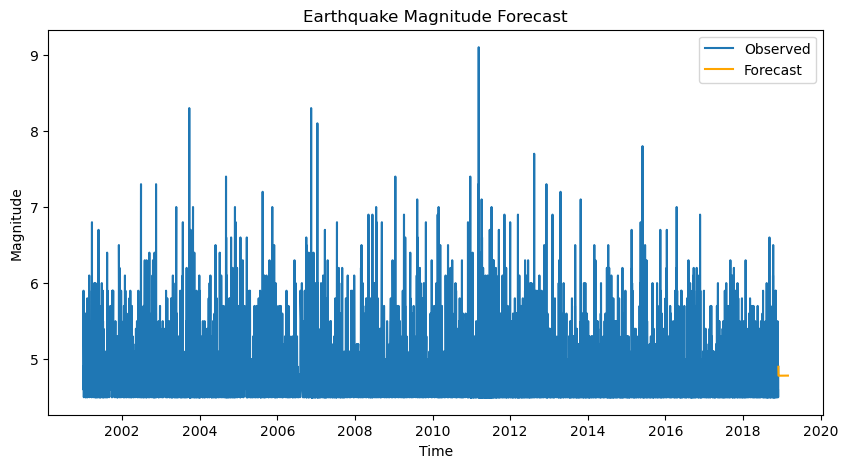

In [29]:
# Plot the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['magnitude'], label='Observed')

# Convert the DataFrame index to UTC
df.index = df.index.tz_convert('UTC')

# Set timezone to UTC for forecast_dates
utc = pytz.UTC
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, closed='right').tz_convert(utc)

# Adjust the forecast list to match the length of forecast_dates
adjusted_forecast = [df['magnitude'].iloc[-1]] + list(forecast)

# Add one more element to forecast_dates to match the length of adjusted_forecast
forecast_dates = forecast_dates.union(pd.DatetimeIndex([forecast_dates[-1] + forecast_dates.freq]))

# Plot the forecasted magnitudes using adjusted_forecast
plt.plot(forecast_dates, adjusted_forecast, label='Forecast', color='orange')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Earthquake Magnitude Forecast')
plt.show()

## 2. Using regression models: XGBoost & CatBoost

## 2.1 XGBoost regression

**Encode the categorical data before training using OneHotEncoder()**

In [254]:
categorical_column = df['magType']
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder to your data to identify unique categories
encoder.fit(df[['magType']])

# Transform the data to one-hot encoded format
encoded_data = encoder.transform(df[['magType']])

# Get the column names for the encoded features
feature_names = encoder.get_feature_names_out(input_features=['magType'])

# Convert the encoded data to a pandas DataFrame with column names
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

In [255]:
encoded_df.head()

,magType_m,magType_mb,magType_ms,magType_mw,magType_mwb,magType_mwc,magType_mwr,magType_mww
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Check for collinearity.**

In [256]:
eigenvalues = np.linalg.eig(encoded_df.corr())
eigenvalues

(array([1.99840144e-15, 1.84848346e+00, 1.08200431e+00, 1.04152782e+00,
        1.02438244e+00, 1.00210886e+00, 1.00141056e+00, 1.00008254e+00]),
 array([[ 6.04522297e-02,  4.67259372e-02, -3.21229335e-02,
         -3.15127015e-02,  3.18282971e-02, -6.04846715e-01,
         -7.89749293e-01,  3.97586087e-02],
        [ 6.76912204e-01, -7.34763143e-01,  3.77593947e-02,
          1.82454135e-02, -1.05141744e-02,  6.54199895e-03,
          6.80523003e-04,  7.17997348e-04],
        [ 6.35498177e-02,  4.91354234e-02, -3.38334256e-02,
         -3.32499158e-02,  3.36720191e-02, -7.82760756e-01,
          6.13217960e-01,  3.75819090e-02],
        [ 1.38775592e-02,  1.06966648e-02, -7.24981937e-03,
         -7.00196924e-03,  6.91330596e-03, -5.16311464e-02,
         -8.17211056e-03, -9.98404254e-01],
        [ 2.34678416e-01,  1.89409861e-01, -1.68572428e-01,
         -2.46083434e-01,  9.00444189e-01,  9.53691141e-02,
          9.57169970e-03,  9.46591938e-03],
        [ 5.05837804e-01,  5.05998

Value 1.99840144e-15 is nearly close to 0, let's remove the column magType_m to avoid collinearity and dummy variable trap.

In [257]:
encoded_df.drop('magType_m',axis=1,inplace=True)

In [268]:
#before merging the encoded dataframe merge the categorical column from  original dataframe
df_no_magType = df.drop('magType',axis=1)
df_no_magType.reset_index(inplace=True)
df_no_magType = pd.concat([df_no_magType, encoded_df], axis=1)

In [269]:
df_no_magType['time'] = pd.to_datetime(df_no_magType['time'])
df_no_magType.set_index('time',inplace=True)

In [270]:
df_no_magType.head()

,latitude,longitude,depth,magnitude,nst,gap,dmin,rms,net,id,...,status,locationSource,magSource,magType_mb,magType_ms,magType_mw,magType_mwb,magType_mwc,magType_mwr,magType_mww
time,,,,,,,,,,,,,,,,,,,,,
2001-01-02 10:53:23.280000+00:00,37.218,138.431,33.0,4.9,43.0,NaN,NaN,0.93,us,usp000a72e,...,reviewed,us,us,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-02 20:29:49.670000+00:00,32.239,141.508,33.0,4.9,32.0,NaN,NaN,0.96,us,usp000a72u,...,reviewed,us,us,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 09:32:54.710000+00:00,45.301,149.941,33.0,4.6,40.0,NaN,NaN,0.82,us,usp000a73h,...,reviewed,us,us,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 14:47:49.540000+00:00,43.932,147.813,33.0,5.9,362.0,NaN,NaN,0.82,us,usp000a73r,...,reviewed,us,hrv,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2001-01-04 04:18:21.430000+00:00,36.981,138.629,21.4,5.3,240.0,NaN,NaN,0.78,us,usp000a74c,...,reviewed,us,hrv,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [272]:
df_xgb = df_no_magType[['magnitude','latitude','longitude','depth','magType_mb', 'magType_ms', 'magType_mw', 'magType_mwb',
       'magType_mwc', 'magType_mwr', 'magType_mww']]

In [273]:
df2 = df_xgb[:13000]
df2.head()

,magnitude,latitude,longitude,depth,magType_mb,magType_ms,magType_mw,magType_mwb,magType_mwc,magType_mwr,magType_mww
time,,,,,,,,,,,
2001-01-02 10:53:23.280000+00:00,4.9,37.218,138.431,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-02 20:29:49.670000+00:00,4.9,32.239,141.508,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 09:32:54.710000+00:00,4.6,45.301,149.941,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-03 14:47:49.540000+00:00,5.9,43.932,147.813,33.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2001-01-04 04:18:21.430000+00:00,5.3,36.981,138.629,21.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Hyperparameter tuning with Optuna

In [108]:
data = df2
# Define the objective function for Optuna to optimize with walk-forward validation
def objective(trial):
    search_space = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    # Define the sub-sample size (adjust this according to your preference)
    sub_sample_size = 0.5  # 50% of the data

    # Create a random sub-sample of the data
    sub_sampled_data = data.sample(frac=sub_sample_size, random_state=42)

    # Split the sub-sampled data into features and target
    X = sub_sampled_data.drop(columns=["magnitude"])
    y = sub_sampled_data["magnitude"]
    
    # Create a rolling window or walk-forward split using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)  # You can adjust the number of splits as needed
    split_indices = tscv.split(X)
    
    # Initialize a list to store the mean squared errors for each step
    mse_list = []

    # Iterate over each step and train and validate the model
    for train_idx, val_idx in split_indices:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create and train the XGBoost model with the current hyperparameters
        model = xgb.XGBRegressor(**search_space)
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        y_pred = model.predict(X_val)

        # Calculate the mean squared error for this step
        mse = ((y_val - y_pred) ** 2).mean()
        mse_list.append(mse)

    # Return the average mean squared error across all steps as the objective to minimize
    return np.mean(mse_list)

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters from the study
best_params = study.best_params
print(best_params)

[I 2023-08-01 10:20:21,420] A new study created in memory with name: no-name-4b68e4e4-f7a6-4d68-b599-a18d457fc944
[I 2023-08-01 10:20:26,448] Trial 0 finished with value: 0.0712780069083786 and parameters: {'n_estimators': 225, 'max_depth': 10, 'learning_rate': 0.025037505785856985, 'subsample': 0.529194801291309, 'colsample_bytree': 0.5803804257899602}. Best is trial 0 with value: 0.0712780069083786.
[I 2023-08-01 10:20:27,807] Trial 1 finished with value: 0.0709965055584557 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.06103213996926218, 'subsample': 0.9594955293949421, 'colsample_bytree': 0.8681932126099765}. Best is trial 1 with value: 0.0709965055584557.
[I 2023-08-01 10:20:30,003] Trial 2 finished with value: 0.0777253134711798 and parameters: {'n_estimators': 85, 'max_depth': 9, 'learning_rate': 0.10900894204616317, 'subsample': 0.57519647616424, 'colsample_bytree': 0.9220095592854491}. Best is trial 1 with value: 0.0709965055584557.
[I 2023-08-01 10:20

{'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.02437469894271589, 'subsample': 0.755244129772574, 'colsample_bytree': 0.6314262555426149}


**Best parameters**

In [149]:
best_params = {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.021196277187170195, 'subsample': 0.5123621523215112, 'colsample_bytree': 0.5311112701921262}

**Perform the rmse test on the training data.**

In [150]:
X = df2.drop(columns=["magnitude"])
y = df2["magnitude"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
# Create and train the XGBoost model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params2)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.2787063505143613


**Perform the rmse test on testing data.**

In [152]:
X_test1 = df1.drop(columns=['magnitude'])[13000:]
y_test1 = df1.magnitude[13000:]

# Make predictions on the test data
y_pred1 = best_model.predict(X_test1)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.26866628189715946


**Merge the predicted data to the original dataframe.**

In [275]:
df3 = df_xgb[13000:]
df3.reset_index(inplace=True)

In [276]:
mag = pd.DataFrame({'predicted_mag': y_pred1})
df4 = pd.concat([df3,mag], axis=1)
df4.set_index('time',inplace=True)

In [278]:
df4.predicted_mag = df4.predicted_mag.round(1)

In [292]:
df4.head()

,predicted_mag,magnitude,latitude,longitude,depth,magType
time,,,,,,
2016-12-28 13:46:14.450000+00:00,4.7,4.8,25.2398,141.1017,203.51,mb
2016-12-29 07:18:40.790000+00:00,4.7,4.6,26.1339,128.6373,7.57,mb
2016-12-30 01:53:22.840000+00:00,4.7,4.6,29.4013,139.4736,398.09,mb
2016-12-30 20:08:26.820000+00:00,5.9,5.1,37.3732,141.4590,9.09,mww
2016-12-31 21:08:02.160000+00:00,4.7,4.8,26.0580,128.7113,8.26,mb


**Create a time series plot.**

In [281]:
y1 = df4.magnitude
y1 = y1.resample('D').median() 
y1 = y1.fillna(y1.mean())

y2 = df4.predicted_mag
y2 = y2.resample('D').median() 
y2 = y2.fillna(y2.mean())

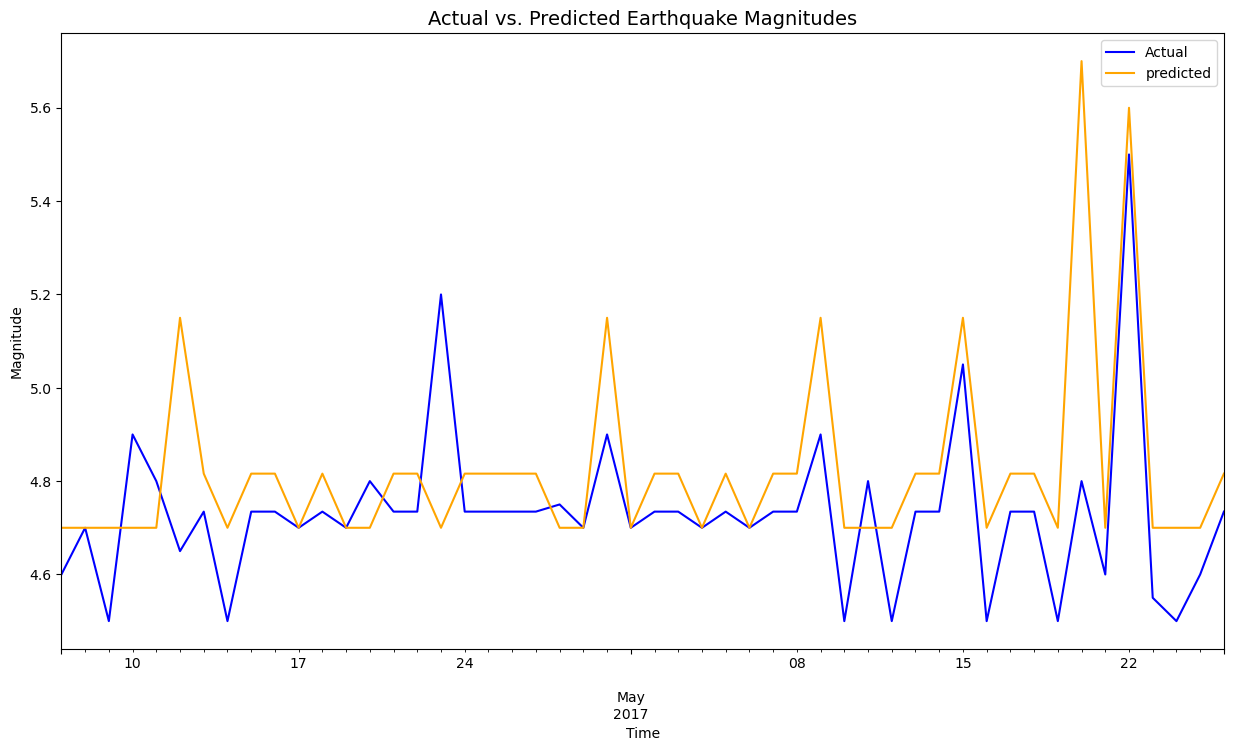

In [282]:
plt.figure(figsize=(15,8))
y1[100:150].plot(color='blue',label='Actual')
y2[100:150].plot(color='orange',label='predicted')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Earthquake Magnitudes', fontsize=14)
plt.legend()
plt.show()

**Find the features with importance.**

In [84]:
# take a look at feature importance
imp = pd.Series(best_model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

magType_mb     0.386130
magType_mww    0.187035
magType_mwc    0.156852
magType_mwb    0.118374
magType_mwr    0.112712
depth          0.013516
latitude       0.008862
longitude      0.007812
magType_ms     0.007355
magType_mw     0.001353
dtype: float32


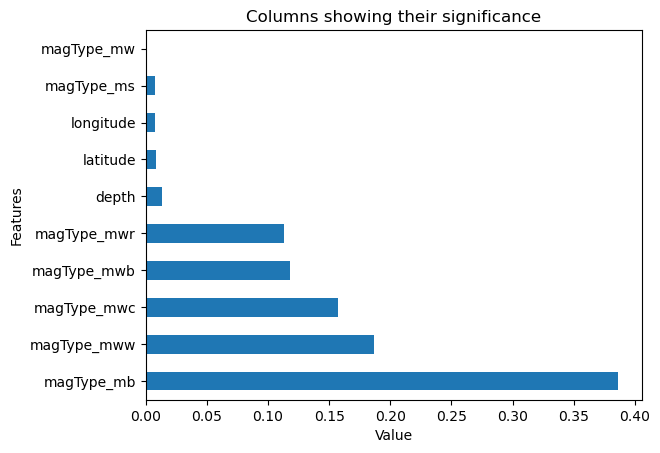

In [85]:
imp.nlargest(10).plot(kind='barh')
plt.title('Columns showing their significance')
plt.xlabel('Value')
plt.ylabel("Features")
plt.show()

Column magType_mb has high impact on the prediction of magnitude followed by magType_mww.

## 2.2 CatBoost regression

In [283]:
df_cb = df[['magnitude','latitude','longitude','depth','magType']]
df1 = df_cb[:13000]

### Hyperparameter tuning with Optuna

In [182]:
# Define the target and features
target_column = 'magnitude'
categorical_features = ['magType']
numerical_features = ['latitude', 'longitude', 'depth']

# Split the data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df1[numerical_features + categorical_features],
    df1[target_column],
    test_size=0.2,
    random_state=42
)

# Create a sub-sample of the data
sub_sample_size = 3000  # Adjust the size of the sub-sample as needed
random_indices = np.random.choice(X_train_full.index, sub_sample_size, replace=False)
X_train = X_train_full.loc[random_indices]
y_train = y_train_full.loc[random_indices]

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 4, 10),
        # Add more hyperparameters to tune as needed
    }

    # Initialize the CatBoostRegressor model with the current hyperparameters
    model = CatBoostRegressor(
        loss_function='RMSE',
        cat_features=categorical_features,
        random_state=42,
        verbose=100,
        **params
    )

    # Perform cross-validation using cross_val_score
    cv_scores = -cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,  # You can adjust the number of folds as needed
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Get the mean RMSE across all cross-validation folds
    mean_rmse = np.sqrt(cv_scores.mean())

    return mean_rmse

# Run the Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Get the best hyperparameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-08-01 11:21:41,869] A new study created in memory with name: no-name-34f58269-54b2-4827-9592-8eafc50bcbca
[I 2023-08-01 11:21:54,106] Trial 0 finished with value: 0.2795253181121841 and parameters: {'iterations': 290, 'learning_rate': 0.14801976327949354, 'depth': 6}. Best is trial 0 with value: 0.2795253181121841.
[I 2023-08-01 11:22:16,218] Trial 1 finished with value: 0.2974268956372254 and parameters: {'iterations': 259, 'learning_rate': 0.33890733619276703, 'depth': 10}. Best is trial 0 with value: 0.2795253181121841.
[I 2023-08-01 11:22:48,489] Trial 2 finished with value: 0.27330411533389637 and parameters: {'iterations': 574, 'learning_rate': 0.015309928269534397, 'depth': 9}. Best is trial 2 with value: 0.27330411533389637.
[I 2023-08-01 11:22:52,717] Trial 3 finished with value: 0.27642772485074263 and parameters: {'iterations': 155, 'learning_rate': 0.17021473052496608, 'depth': 5}. Best is trial 2 with value: 0.27330411533389637.
[I 2023-08-01 11:23:08,919] Trial 4 

Best Hyperparameters: {'iterations': 864, 'learning_rate': 0.01243067675525661, 'depth': 5}


**Best parameters.**

In [183]:
best_params2 = {'iterations': 864, 'learning_rate': 0.01243067675525661, 'depth': 5}

**Perform the rmse test on training data.**

In [197]:
# Train the best model on the full training data
best_model = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=categorical_features,
    random_state=42,
    verbose=100,
    **best_params2
)
best_model.fit(X_train_full, y_train_full)

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse}")

0:	learn: 0.3817262	total: 20ms	remaining: 17.3s
100:	learn: 0.2886758	total: 1.87s	remaining: 14.1s
200:	learn: 0.2768788	total: 3.56s	remaining: 11.7s
300:	learn: 0.2740521	total: 5.35s	remaining: 10s
400:	learn: 0.2724505	total: 7.03s	remaining: 8.12s
500:	learn: 0.2712611	total: 8.7s	remaining: 6.3s
600:	learn: 0.2703679	total: 10.5s	remaining: 4.58s
700:	learn: 0.2694153	total: 12.2s	remaining: 2.83s
800:	learn: 0.2685630	total: 13.9s	remaining: 1.09s
863:	learn: 0.2680152	total: 15s	remaining: 0us
Best Model RMSE: 0.2767938944932754


**Perform the rmse test on testing data.**

In [287]:
df2 = df_cb[13000:]

In [199]:
X_test1 = df2.drop(columns=['magnitude'])[13000:]
y_test1 = df2.magnitude[13000:]

# Make predictions on the test data
y_pred1 = best_model.predict(X_test1)

# Evaluate the best model's performance (Root Mean Squared Error, RMSE)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 0.2667367343326928


**Merge the predicted data to the original dataframe.**

In [288]:
df2.reset_index(inplace=True)

mag = pd.DataFrame({'predicted_mag': y_pred1})
df4 = pd.concat([mag, df2], axis=1)
df4.set_index('time',inplace=True)

df4.predicted_mag = df4.predicted_mag.round(1)

y1 = df4.magnitude
y1 = y1.resample('D').median() 
y1 = y1.fillna(y1.mean())

y2 = df4.predicted_mag
y2 = y2.resample('D').median() 
y2 = y2.fillna(y2.mean())

In [290]:
df4.head()

,predicted_mag,magnitude,latitude,longitude,depth,magType
time,,,,,,
2016-12-28 13:46:14.450000+00:00,4.7,4.8,25.2398,141.1017,203.51,mb
2016-12-29 07:18:40.790000+00:00,4.7,4.6,26.1339,128.6373,7.57,mb
2016-12-30 01:53:22.840000+00:00,4.7,4.6,29.4013,139.4736,398.09,mb
2016-12-30 20:08:26.820000+00:00,5.9,5.1,37.3732,141.4590,9.09,mww
2016-12-31 21:08:02.160000+00:00,4.7,4.8,26.0580,128.7113,8.26,mb


**Create a time series plot.**

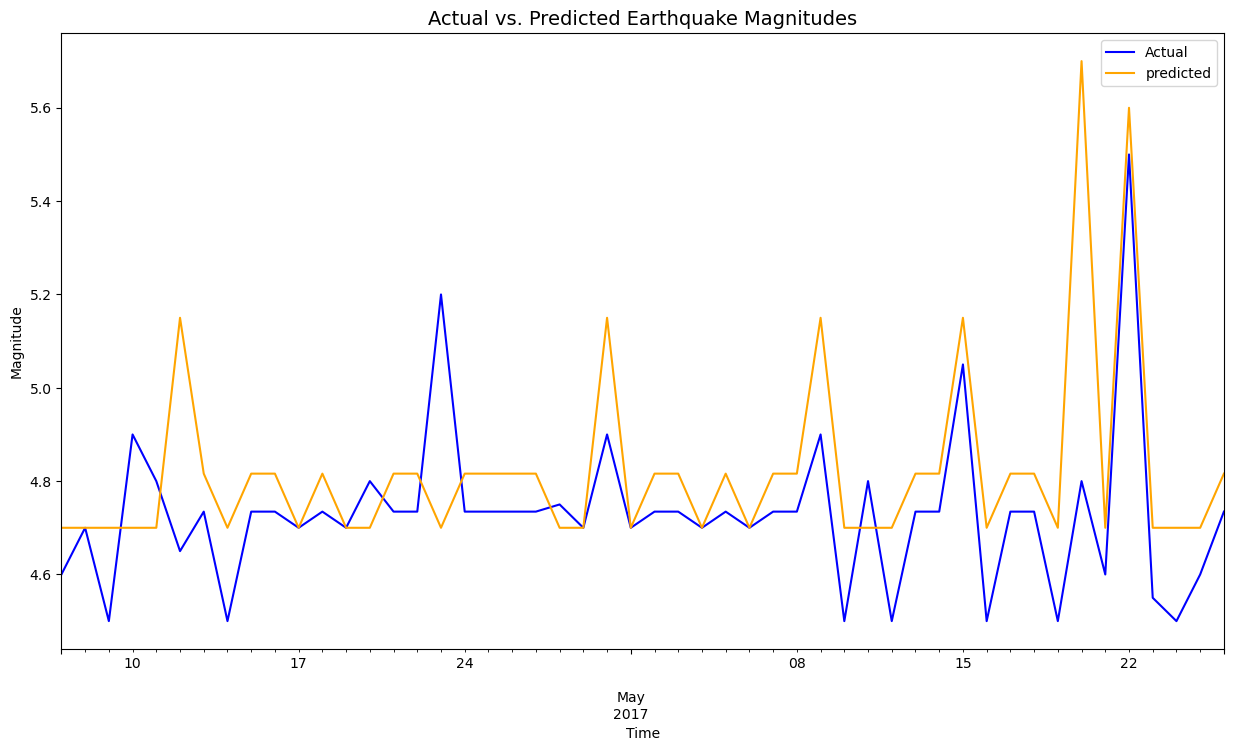

In [210]:
plt.figure(figsize=(15,8))
y1[100:150].plot(color='blue',label='Actual')
y2[100:150].plot(color='orange',label='predicted')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Actual vs. Predicted Earthquake Magnitudes', fontsize=14)
plt.legend()
plt.show()

**Find features with importance.**

In [190]:
# take a look at feature importance
imp = pd.Series(best_model.feature_importances_, index=X_test1.columns)
imp = imp.sort_values(ascending=False)
print(imp)

magType      75.229768
depth        11.576601
latitude      7.037678
longitude     6.155953
dtype: float64


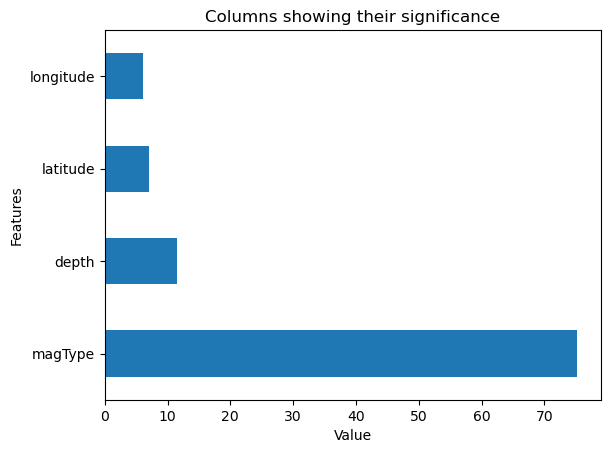

In [191]:
imp.nlargest(10).plot(kind='barh')
plt.title('Columns showing their significance')
plt.xlabel('Value')
plt.ylabel("Features")
plt.show()

Column magType has high impact on the predition of magnitude.

# Evaluation

In [193]:
data = [{'CatBoost':0.277, 'XGBoost':0.279}, {'CatBoost':0.267, 'XGBoost':0.269}]

rmse = pd.DataFrame(data,index=['Training','Testing'])
rmse

,CatBoost,XGBoost
Training,0.277,0.279
Testing,0.267,0.269


Looking at the plots and the rmse scores, both CatBoost and XGBoost have almost similar performace. If we have to pick one between two CatBoost can be picked as it's rmse score slightly lower than XGBoost's score.